In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
#import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import dill as pickle
from copy import deepcopy

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from mcmodels.core.utils import get_ccf_data

from mcmodels.core import VoxelModelCache
from mcmodels.connectivity.creation import get_connectivity_matrices3
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss, Crossval
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists,CrossvalNW

def plot_loss(meanloss):
    fig = plt.figure(figsize=(60,40))
    ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
    ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
    ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

    mask = np.zeros_like(meanloss)
    mask[np.tril_indices_from(mask)] = True

    sns.heatmap(meanloss, ax = ax1, annot=True, cmap="YlGnBu", linecolor='b', cbar = False)
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(meanloss.columns,rotation=40)

    sns.heatmap((pd.DataFrame(meanloss.mean(axis=0))).transpose(), ax=ax2,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap(pd.DataFrame(meanloss.mean(axis=1)), ax=ax3,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structures.npy')
major_structure_ids = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structure_ids.npy')
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_leaves_v3.npy')

annotation/ccf_2017


In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(major_structure_ids)

connectivity_data.ai_map = ai_map
connectivity_data.get_crelines(data_info)
connectivity_data.get_summarystructures(data_info)
connectivity_data.summary_structures = {sid: connectivity_data.structure_datas[sid].summary_structures for sid in major_structure_ids}#get_indices_2ormore(connectivity_data.leafs)
connectivity_data.leafs = leafs

sid0 = list(connectivity_data.structure_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
targ_ord = ontological_order_leaves
source_ord = ontological_order_leaves
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=1)
#ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=2)
connectivity_data.get_regionalized_normalized_data(source_ord, ipsi_targetkey, contra_targetkey)

frac_learn = np.ones(12)

#get surfaces summary
#sumsurf NW

512
703
1089
1097
315
313
354
698
771
803
477
549


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:221: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:221: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)


In [68]:
#connectivity_data.cresum2_evalindices = get_eval_indices(connectivity_data.cresum2_index_matrices)
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)
#connectivity_data.cresum2_leaf2_evalindices = get_eval_indices(connectivity_data.cresum2_leaf2_index_matrices)


gammas = np.asarray([0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
reg_proj_norm = {sid: connectivity_data.structure_datas[sid].reg_proj_norm for sid in major_structure_ids}
#sum2_index_matrices = {sid: connectivity_data.sum2_index_matrices[sid] for sid in major_structure_ids} 
#cresum2_evalindices = {sid: connectivity_data.cresum2_evalindices[sid] for sid in major_structure_ids} 
#cresum2_leaf2_evalindices = {sid: connectivity_data.cresum2_leaf2_evalindices[sid] for sid in major_structure_ids} 
creleaf2_evalindices = {sid: connectivity_data.creleaf2_evalindices[sid] for sid in major_structure_ids} 
crelines = {sid: connectivity_data.creline[sid] for sid in major_structure_ids}
#look at visp6a prediction accuracy
#lets just make the eval plots
cre2_index_matrices = {sid: connectivity_data.cre2_index_matrices[sid] for sid in major_structure_ids}
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.get_creleaf_combos()
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)
connectivity_data.get_creleaf_combos()
connectivity_data.cre2_index_matrices = get_indices_2ormore(crelines)
connectivity_data.major2_index_matrices = {}
for sid in major_structure_ids:
     connectivity_data.major2_index_matrices[sid] =  np.expand_dims(np.ones(crelines[sid].shape),0)
major2_index_matrices = {sid:connectivity_data.major2_index_matrices[sid] for sid in major_structure_ids}

wtmajor2_index_matrices = {}
for sid in major_structure_ids:
    wtm = np.zeros(major2_index_matrices[sid].shape) 
    #print(wtm.shape)
    wtmajor2_index_matrices[sid] = wtm[:,np.where(crelines[sid] == 'C57BL/6J')[0]] = 1
#get_indices2(connectivity_data.creline[sid], np.asarray(['C57BL/6J']),leafs[sid])

#ncresum2_leaf2 = np.zeros(12)
#ncresum2 = np.zeros(12)
ncreleaf2 = np.zeros(12)
ntotal = np.zeros(12)
for i in range(12):
    sid = major_structure_ids[i]
    ntotal[i] = connectivity_data.structure_datas[sid].reg_proj.shape[0]
    #ncresum2_leaf2[i] =len(cresum2_leaf2_evalindices[sid])
    #ncresum2[i] = len(cresum2_evalindices[sid])
    ncreleaf2[i] = len(creleaf2_evalindices[sid])

df = pd.DataFrame([ntotal,  ncreleaf2], dtype = int, index=['Total','Cre-Leaf'], columns = major_structures[reo]).transpose()
#df = pd.DataFrame([ntotal, ncresum2, ncresum2_leaf2,  ncreleaf2], dtype = int, index=['Total','Cre-Summary','Cre-Summary, Leaf','Cre-Leaf']).transpose()
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Total &  Cre-Leaf \\
\midrule
Isocortex &     36 &         4 \\
OLF       &      7 &         2 \\
HPF       &    122 &        62 \\
CTXsp     &     85 &        41 \\
STR       &   1128 &       732 \\
PAL       &     68 &        18 \\
TH        &     46 &         7 \\
HY        &     35 &        17 \\
MB        &     33 &         8 \\
P         &     30 &        11 \\
MY        &     78 &        45 \\
CB        &     83 &        29 \\
\bottomrule
\end{tabular}



In [29]:
creleaf2_index_matrices = {sid: connectivity_data.creleaf2_index_matrices[sid] for sid in major_structure_ids} 
leaf2_index_matrices = {sid: connectivity_data.leaf2_index_matrices[sid] for sid in major_structure_ids} 
pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
distances = pds

##{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_major_creleaf2 = CrossvalNW(reg_proj_norm, distances,major2_index_matrices, creleaf2_evalindices,gammas)
nw_major_creleaf2.gammas = gammas
nw_major_creleaf2.predictions = nw_major_creleaf2.get_predictions()
nw_major_creleaf2.get_results_loocv()
nw_major_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

nw_majorwt_creleaf2 = CrossvalNW(reg_proj_norm, distances,wtmajor2_index_matrices, creleaf2_evalindices,gammas)
nw_majorwt_creleaf2.gammas = gammas
nw_majorwt_creleaf2.predictions = nw_major_creleaf2.get_predictions()
nw_majorwt_creleaf2.get_results_loocv()
nw_majorwt_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)


# nw_sum_cresum2leaf2 = CrossvalNW(reg_proj_norm, distances,sum2_index_matrices, cresum2_leaf2_evalindices,gammas)
# nw_sum_cresum2leaf2.gammas = gammas
# nw_sum_cresum2leaf2.predictions = nw_sum_cresum2leaf2.get_predictions()
# nw_sum_cresum2leaf2.get_results_loocv()
# nw_sum_cresum2leaf2.get_results_weightedloocv(connectivity_data.summary_structures,crelines,ia_map)
#nw_sum_creleaf2.meanloss

nw_leaf_creleaf2 = CrossvalNW(reg_proj_norm, distances,leaf2_index_matrices, creleaf2_evalindices,gammas)
nw_leaf_creleaf2.gammas = gammas# ds
nw_leaf_creleaf2.predictions = nw_leaf_creleaf2.get_predictions()
nw_leaf_creleaf2.get_results_loocv()
nw_leaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

#distances = pds#{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_creleaf_creleaf2 = CrossvalNW(reg_proj_norm, distances,creleaf2_index_matrices, creleaf2_evalindices,gammas)
nw_creleaf_creleaf2.gammas = gammas# ds
nw_creleaf_creleaf2.predictions = nw_creleaf_creleaf2.get_predictions()
nw_creleaf_creleaf2.get_results_loocv()
nw_creleaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

#distances = pds#{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_cremajor_creleaf2 = CrossvalNW(reg_proj_norm, distances,cre2_index_matrices, creleaf2_evalindices,gammas)
nw_cremajor_creleaf2.gammas = gammas# ds
nw_cremajor_creleaf2.predictions = nw_cremajor_creleaf2.get_predictions()
nw_cremajor_creleaf2.get_results_loocv()
nw_cremajor_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

mean_gammas = np.ones(12)*0.000001
mean_creleaf_creleaf2 = CrossvalNW(reg_proj_norm, distances, creleaf2_index_matrices, creleaf2_evalindices,mean_gammas)
mean_creleaf_creleaf2.gammas = mean_gammas# ds
mean_creleaf_creleaf2.predictions = mean_creleaf_creleaf2.get_predictions()
mean_creleaf_creleaf2.get_results_loocv()
mean_creleaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:43: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [33]:
#get surfaces leaf
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_leaf = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m])
    connectivity_data.structure_datas[sid].smoothed_losses_leaf = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_leaf,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_leaf.cre_distances_cv)
    

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/expectedloss/shapeconstrained.py:47: RuntimeWarning: invalid value encountered in true_divide
  coordinates_normed = coordinates / np.linalg.

In [35]:
leaf2_index_matrices = {sid: connectivity_data.leaf2_index_matrices[sid] for sid in major_structure_ids} 
distances = {sid: connectivity_data.structure_datas[sid].smoothed_losses_leaf for sid in major_structure_ids}
twostage_leaf_creleaf2 = CrossvalNW(reg_proj_norm, distances, leaf2_index_matrices, creleaf2_evalindices,gammas)
twostage_leaf_creleaf2.gammas = gammas #ds
twostage_leaf_creleaf2.predictions = twostage_leaf_creleaf2.get_predictions()
twostage_leaf_creleaf2.get_results_loocv()
twostage_leaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

In [47]:
#el_labels = np.zeros(150, dtype = str)
models = np.asarray(['Mean','NW','NW','NW','NW','NW','EL'])
datas = np.asarray([r"$I_c \cap I_L$",
                   r"$I_c \cap I_M$",
                   r"$I_c \cap I_L$",
                  r"$I_{wt} \cap I_M$",
                  r"$I_c \cap I_L$",
                  r"$I_M$"  ,
                  r"$I_L$"])
multi_ind = np.vstack([models,datas])
multi_ind = np.asarray(multi_ind, dtype = str)
multi_ind = list(zip(*multi_ind))
multi_ind = pd.MultiIndex.from_tuples(multi_ind, names=[r"$\widehat f$",r"$\mathcal D$"])


In [65]:
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
results = pd.DataFrame([mean_creleaf_creleaf2.meanloss_weighted,
nw_cremajor_creleaf2.meanloss_weighted,
nw_creleaf_creleaf2.meanloss_weighted,
nw_leaf_creleaf2.meanloss_weighted,
nw_majorwt_creleaf2.meanloss_weighted,
nw_major_creleaf2.meanloss_weighted,
twostage_leaf_creleaf2.meanloss_weighted], index = multi_ind, columns = major_structures[reo]).transpose()#, cre2_index_matrices

In [66]:
trunc = lambda x: math.trunc(1000 * x) / 1000;

results = results.applymap(trunc)

In [67]:
print(results.to_latex(index=True,escape=False))
#{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}


\begin{tabular}{lrrrrrrr}
\toprule
$\widehat f$ &           Mean & \multicolumn{5}{l}{NW} &     EL \\
$\mathcal D$ & $I_c \cap I_L$ & $I_c \cap I_M$ & $I_c \cap I_L$ & $I_{wt} \cap I_M$ & $I_c \cap I_L$ &  $I_M$ &  $I_L$ \\
\midrule
Isocortex &          0.062 &          0.061 &          0.062 &             0.067 &          0.111 &  0.111 &  0.068 \\
OLF       &          0.758 &          0.758 &          0.758 &             0.758 &          0.758 &  0.758 &  0.758 \\
HPF       &          0.176 &          0.335 &          0.170 &             0.201 &          0.235 &  0.235 &  0.148 \\
CTXsp     &          0.388 &          0.392 &          0.381 &             0.359 &          0.338 &  0.338 &  0.331 \\
STR       &          0.264 &          0.256 &          0.257 &             0.358 &          0.370 &  0.370 &  0.246 \\
PAL       &          0.213 &          0.232 &          0.201 &             0.276 &          0.285 &  0.285 &  0.195 \\
TH        &          0.261 &          0.340 &        

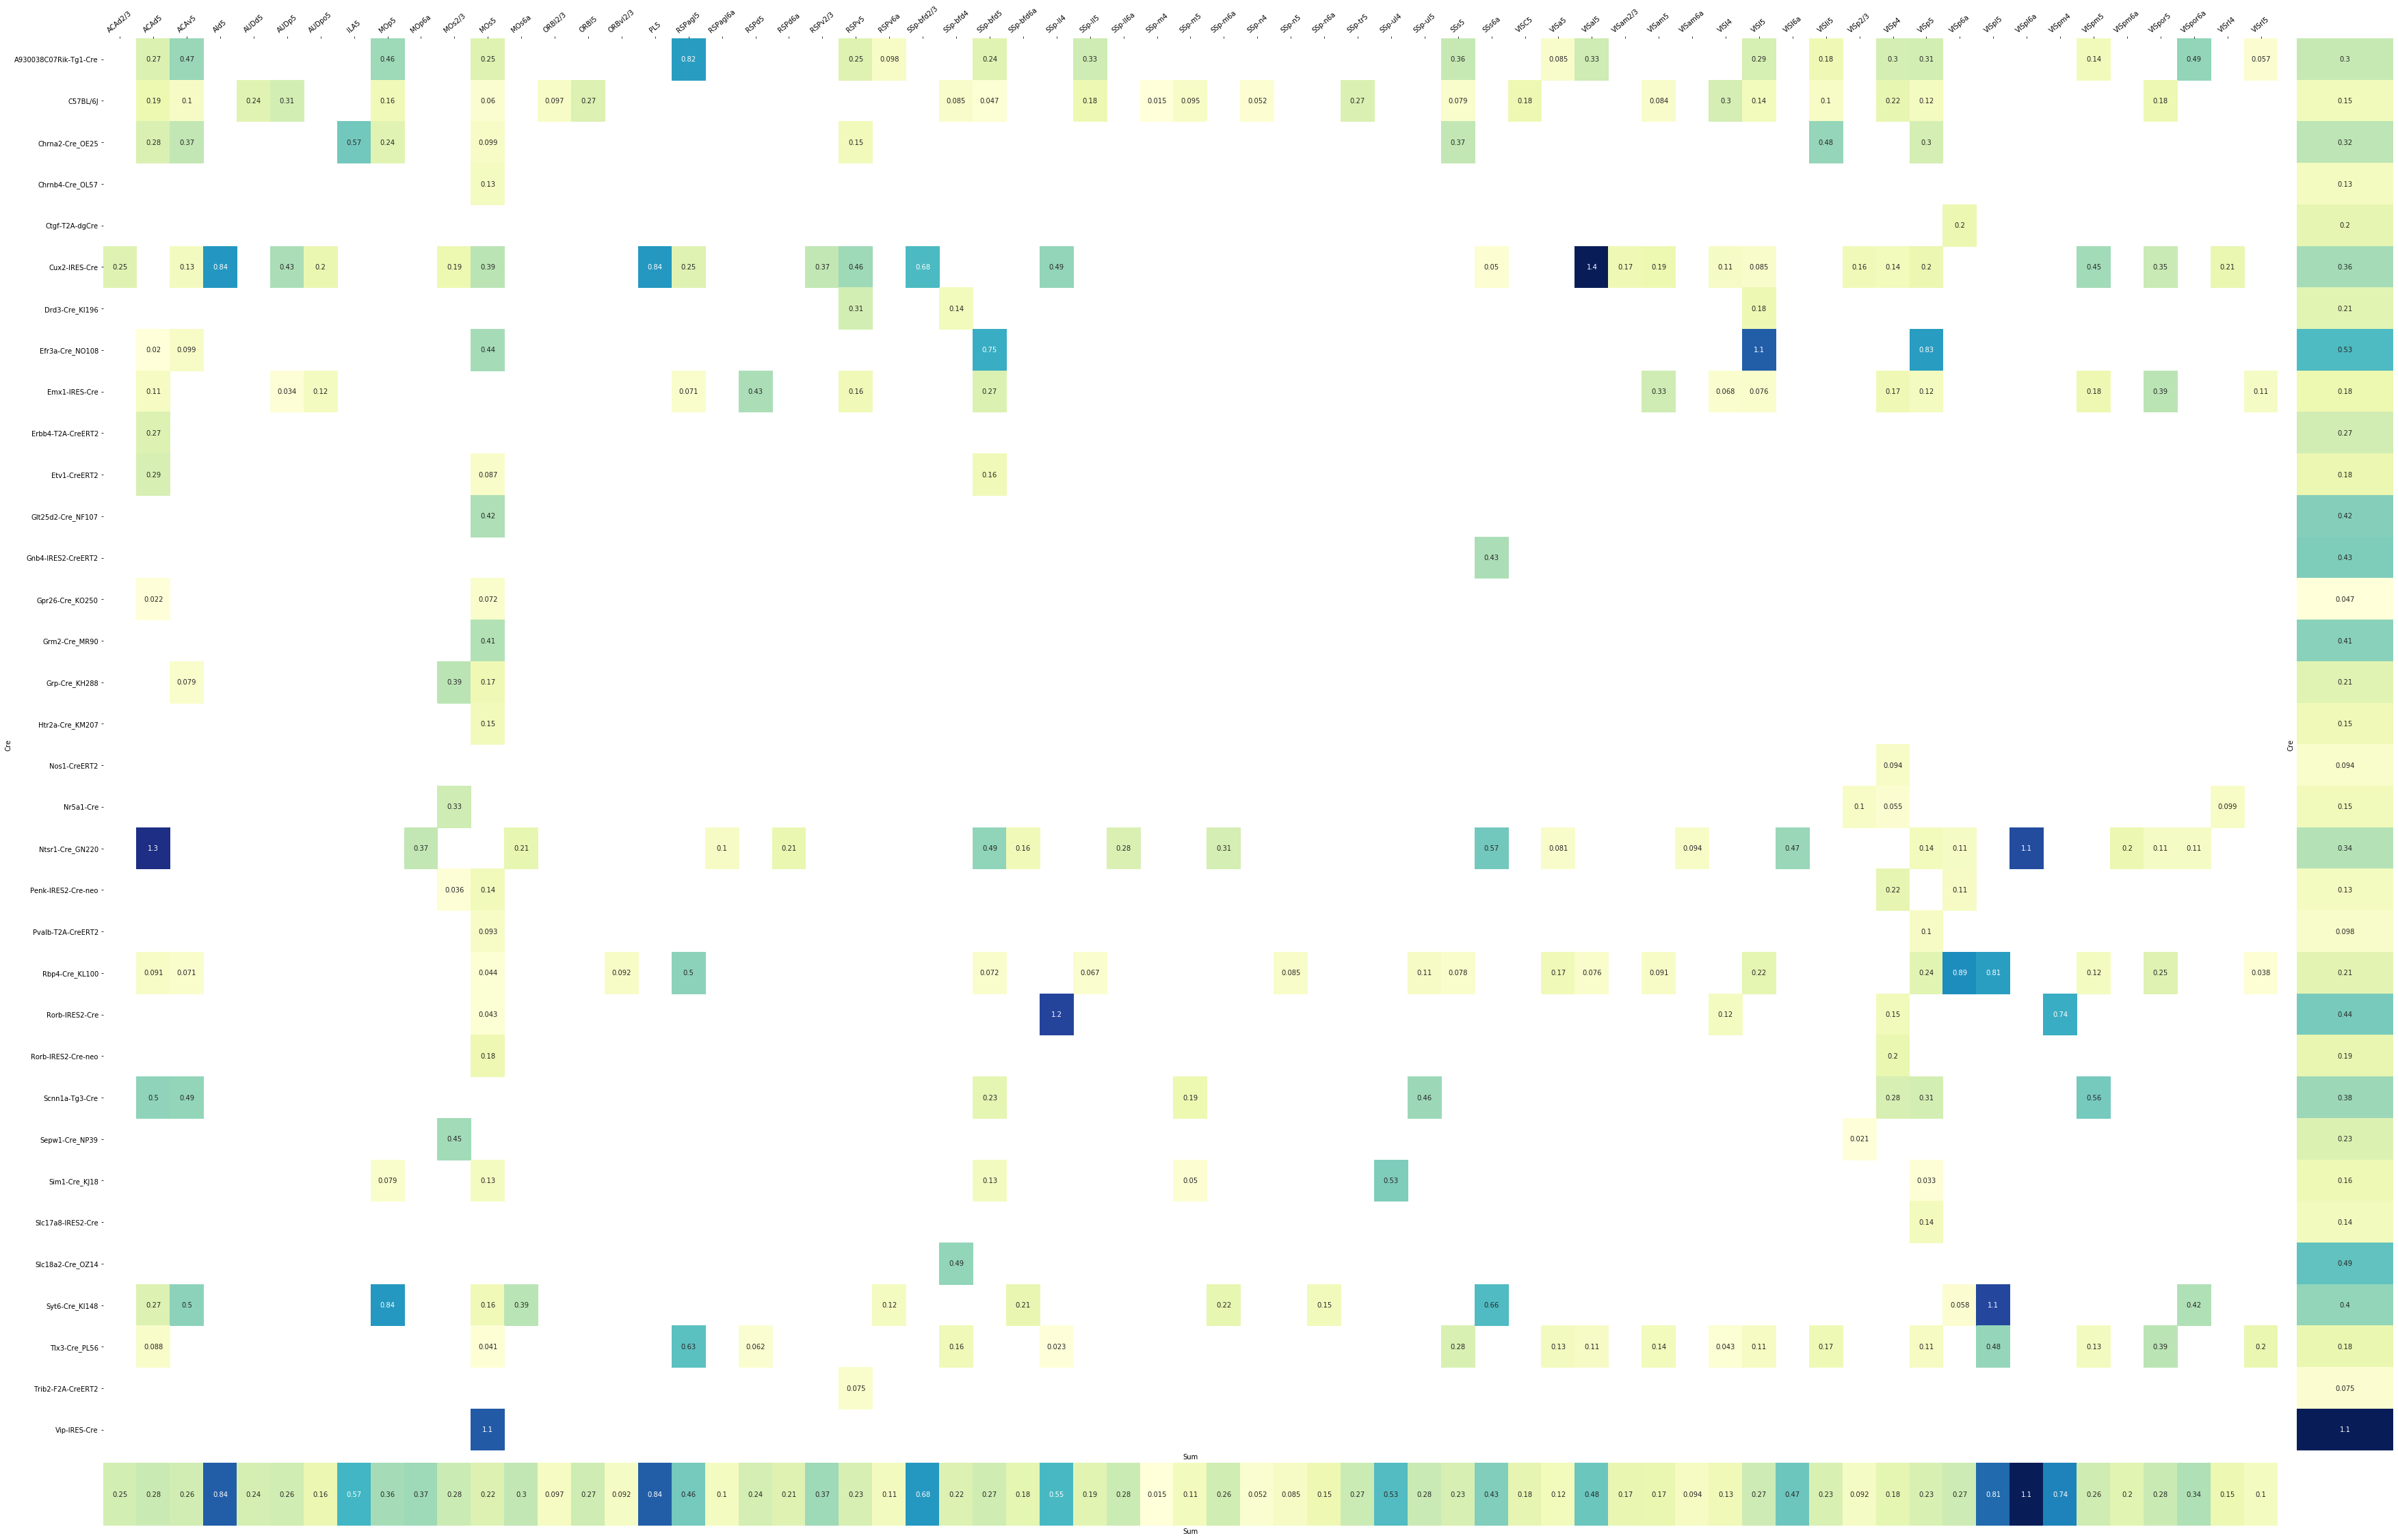

In [63]:
plot_loss(nw_creleaf_creleaf2.weighted_losses[315])

In [ ]:
#%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')
plot_loss_scatter(connectivity_data.structure_datas[315].loss_surface_cv_str)
plt.scatter(np.log10(loocvpredictions[315][5][0]), np.log10(connectivity_data.structure_datas[315].reg_proj_norm[0]))